# An introductory Genetic Programming Algorithm

This notebook provides an introducton to genetic programming.

## Basic Concepts

Common imports for the program

In [91]:
from random import shuffle,random, randint, choice, uniform
import datetime
import time
import operator
from math import *
import matplotlib.pyplot as plt
    

## Program Settings

Create a dictionary with the common program settings/parameters

In [118]:
runparameters = dict()
runparameters['RUN_ID'] = (datetime.datetime.now().strftime("%Y%m%d%H%M%S%f"))
runparameters['PROGRAM_DEPTH'] = 5
runparameters['MAX_PROGRAM_DEPTH'] = 12
runparameters['POPULATION_SIZE'] = 200
runparameters['TOURNMENT_SIZE'] = 4
runparameters['MAX_GENERATIONS'] = 100
runparameters['TREE_GENERATION_MODE'] = 'rhah'
runparameters['CROSSOVER_RATE'] = 0.9
runparameters['MUTATION_RATE'] = 0.1
runparameters['N_VARIABLES'] = 1
runparameters['TRAININGTESTRATIO'] = 0.8
runparameters['VARIABLERATIO'] = 0.99
runparameters['DATAFILENAME'] = 'fittable_sin.txt'
runparameters['OPERATORLIST'] = ['+','*','/','-']
#print(runparameters)  #Uncoment this for some debugging if needed

## Read the Data

Read the data file and split it into training and test sets

In [72]:
def readdatafile(filename):
    """data should be separated by semicolons and the last column should be the result"""
    import csv
    with open(filename, 'r') as f:
        reader = csv.reader(f,delimiter=';')
        outp = [list(map(float,rec)) for rec in reader]
    return outp

In [73]:
fulldataset=readdatafile(runparameters['DATAFILENAME'])
#Since we want random samples for the training and test sets will shuffle the list
shuffle(fulldataset)
#do the spliting
trainingsetsize=int(len(fulldataset)*runparameters['TRAININGTESTRATIO'])
testsetsize=len(fulldataset)-trainingsetsize
trainingset,testset=fulldataset[:trainingsetsize],fulldataset[-testsetsize:]
#sort them again just for intuition sake
testset.sort()
trainingset.sort()

## Lets look at the sets

This will create a plot of the training and test sets.
The testset looks more ruged because of the fewer samples it contains

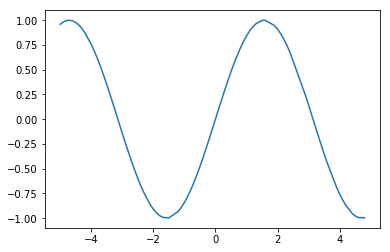

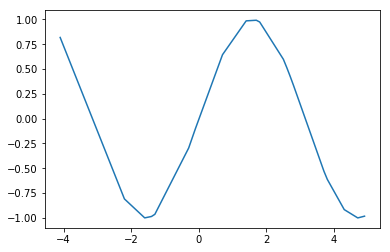

In [74]:
x=list()
x[:]=[]
y=list()
y[:]=[]
for n in trainingset:
    x.append(n[0])
    y.append(n[1])
plt.clf()
plt.plot( x,y)
plt.show()

x=list()
x[:]=[]
y=list()
y[:]=[]
for n in testset:
    x.append(n[0])
    y.append(n[1])
plt.clf()
plt.plot(x,y)
plt.show()

### RPN Parser

We will be parsing the RPN files, the function bellow evaluates the RPNexpression and returns the achieved value

In [98]:
"""RPN PARSER"""
def parseRPN(expression):
    """Parses and calculates the result of a RPN expression
        takes a list in the form of ['2','2','*']
    """""
    def safe_divide(darg1, darg2):
        # Here we can penalize asymptotes with by increasing the ERROR_VALUE to a
        # large number
        ERROR_VALUE = 1.
        try:
            return darg1 / darg2
        except ZeroDivisionError:
            return ERROR_VALUE

    function_twoargs = {'*': operator.mul, '/': safe_divide, '+': operator.add, '-': operator.sub}
    stack = []
    for val in expression:
        result = None
        if val in function_twoargs:
            arg2 = stack.pop()
            arg1 = stack.pop()
            result = function_twoargs[val](arg1, arg2)
        else:
            result = float(val)
        stack.append(result)
    return result

Test the RPN parser

In [102]:
print(parseRPN(['2','3','*']))
print(parseRPN(['2','3','*','6','+']))

6.0
12.0


# Population

The population is a list of potencial solutions

To generate the pupulation we need to create some RPN expressions, it is easier to do so recursively

In [124]:
def generate_RPN_expr(prevtree,depth,growthtype,nvars,varratio):
    
    def selectRandomVariable(nvars):
        return 'x'+str(randint(0,nvars-1))

    tmptree=""
    if growthtype=='full':
        if depth>0:
            if random()>=0.5 or prevtree=="":
                #cria subtree
                tmptree=str(generate_RPN_expr(tmptree,depth-1,growthtype,nvars,varratio)) + str(generate_RPN_expr(tmptree,depth-1,growthtype,nvars,varratio)) + str(choice(runparameters['OPERATORLIST'])) + " " + tmptree
            else:
                #assigna valor
                tmptree=(str(uniform(-5,5))) + " " + tmptree
        else:
            if random()>=varratio:
                tmptree=(str(uniform(-5,5))) + " " + tmptree
            else:
                tmptree=selectRandomVariable(nvars) + " " + tmptree
    elif growthtype=='grow':
        if depth > 0:
            if random() >= 0.5 :
                tmptree = str(generate_RPN_expr(tmptree, depth - 1,growthtype,nvars,varratio)) + str(generate_RPN_expr(tmptree, depth - 1,growthtype,nvars,varratio)) + str(choice(runparameters['OPERATORLIST'])) + " " + tmptree
            else:
                # assigna valor
                if random() >= varratio:
                    tmptree = (str(uniform(-5,5))) + " " + tmptree
                else:
                    tmptree = selectRandomVariable(nvars) + " " + tmptree
        else:
            if random() >= varratio:
                tmptree = (str(uniform(-5,5))) + " " + tmptree
            else:
                tmptree = selectRandomVariable(nvars) + " " + tmptree
    else:
        print ('EEEKKKKKKKKKKKK EL PROBLEMO !!!')
    return tmptree #"(" + tmptree + ")"

In [ ]:
#this function generates the population
def generate_population(popsize, progdepth, method, nvars, varratio):
    pop=list()
    components=list()
    pop[:]=[]

    if method is 'grow' or method is 'full':
        for i in range(0,popsize):
            tmp=generate_RPN_expr("",progdepth,method,nvars,varratio)
            tmp=tmp[0:len(tmp)-1]
            #components[:]=[]
            components = [''.join(i) for i in tmp.split(' ')]
            if len(components)==2:
                print('error generate init pop >>> 2')
            if len(components)==0:
                print('error generate init pop >>> 0')
            pop.append(components)
    elif method is 'rhah':
        #todo fix population size problem
        #dividir a populacao em degraus
        nsteps=int(popsize/progdepth)
        for i in range(0,progdepth):
            for k in range(0,nsteps):
                ##dois em dois
                if k%2==0:
                    tmp = generate_RPN_expr("", i, 'grow',nvars,varratio)
                else:
                    tmp = generate_RPN_expr("", i, 'full',nvars,varratio)

                tmp = tmp[0:len(tmp) - 1]
                # components[:]=[]
                components = [''.join(i) for i in tmp.split(' ')]
                if len(components) == 2:
                    print('error generate init pop >>> 2')
                if len(components) == 0:
                    print('error generate init pop >>> 0')
                pop.append(components)

    return pop

### Now we can generate the population

Lets now initialize the original population

In [125]:
population=list()
population[:]=[]


population=generate_population(runparameters['POPULATION_SIZE'],
                               runparameters['PROGRAM_DEPTH'],
                               runparameters['TREE_GENERATION_MODE'],
                               runparameters['N_VARIABLES'],
                               runparameters['VARIABLERATIO'])

In [128]:
for i in population:print(i)

['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0']
['x0', 'x0', '+']
['x0', 'x0', '/']
['x0']
['x0', 'x0', '/']
['x0']
['x0', 'x0', '+']
['x0', 'x0', '/']
['x0', 'x0', '+']
['x0', 'x0', '-']
['x0', 'x0', '+']
['x0']
['x0', 'x0', '-']
['x0', 'x0', '/']
['x0', 'x0', '+']
['x0', 'x0', '-']
['x0', 'x0', '-']
['x0']
['x0', 'x0', '-']
['x0']
['x0', 'x0', '+']
['x0', 'x0', '+']
['x0', 'x0', '-']
['x0']
['x0', '-0.6750116716914745', '*']
['x0']
['x0', 'x0', '-']
['x0']
['x0', 'x0', '/']
['x0', 'x0', '/']
['x0', 'x0', '-']
['x0', 'x0', '/']
['x0', 'x0', '/']
['x0', 'x0', '-']
['x0', 'x0', '+']
['x0', 'x0', '-']
['x0', 'x0', '*']
['x0']
['x0', 'x0', '*']
['x0', 'x0', '*']
['x0', 'x0', '+']
['x0']
['x0', 'x0', '-', 'x0', 'x0', '-', '-']
['x0', 'x0', '-', 'x0', '+']
['x0',